In [74]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import pandas as pd
from sklearn.metrics import average_precision_score
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns

In [80]:
pwd

'/home/nakyung/projects/BDAIFin'

In [84]:
test = pd.read_parquet("data/online/test_raw.parquet")
train = pd.read_parquet("data/online/train_oss.parquet")

In [85]:
df = pd.concat([train, test], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886255 entries, 0 to 178153
Data columns (total 58 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   client_id                        886255 non-null  int64  
 1   card_id                          886255 non-null  int64  
 2   amount                           886255 non-null  float32
 3   merchant_id                      886255 non-null  int64  
 4   current_age                      886255 non-null  int64  
 5   retirement_age                   886255 non-null  int64  
 6   birth_year                       886255 non-null  int64  
 7   birth_month                      886255 non-null  int8   
 8   latitude                         886255 non-null  float64
 9   longitude                        886255 non-null  float64
 10  per_capita_income                886255 non-null  float32
 11  yearly_income                    886255 non-null  float32
 12  total_d

In [86]:
df.shape

(886255, 58)

In [87]:
df.shape

(886255, 58)

In [88]:
# amount log 컬럼 추가
df = df[df["amount"] >= 0].copy()
df["log_amount"] = np.log1p(df["amount"])
df.shape

(882143, 59)

In [89]:
# Num_cards_issued drop
df.drop("num_cards_issued", axis=1, inplace=True)
df.shape

(882143, 58)

In [90]:
# hour
df["hour_sin"] = np.sin(2*np.pi*df["tx_hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["tx_hour"]/24)

In [91]:
# month
df["month_sin"] = np.sin(2 * np.pi * df["tx_month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["tx_month"] / 12)

In [92]:
# day
df.drop("tx_day", axis=1, inplace=True) 

In [93]:
# err
df.drop(columns=["err_bad_pin", "err_bad_zipcode", "err_technical_glitch"], inplace=True)

In [94]:
# months_to_expire_calc
tx_total_month = df["tx_year"] * 12 + df["tx_month"]
expire_total_month = df["expires_year"] * 12 + df["expires_month"]
df["months_to_expire_calc"] = expire_total_month - tx_total_month

In [95]:
# mccg_Medical
df.drop("mccg_Medical", axis=1, inplace=True)

In [96]:
df.shape

(882143, 58)

In [97]:
df.drop("birth_year", axis=1, inplace=True)

In [98]:
df.drop("merchant_id", axis=1, inplace=True)

In [99]:
df.drop("birth_month", axis=1, inplace=True)

In [100]:
df.drop("retirement_age", axis=1, inplace=True)

In [101]:
df.drop("is_online", axis=1, inplace=True)

In [102]:
df.drop(columns=["acct_open_year", "acct_open_month", "expires_year", "expires_month", "months_to_expire_calc"], inplace=True)

In [103]:
df.drop("amount", axis=1, inplace=True)

In [104]:
df.drop(columns=["has_error", "distance_imputed"], axis=1, inplace=True)

In [105]:
df.drop(columns=["latitude", "longitude"], inplace=True)

In [106]:
df.columns

Index(['client_id', 'card_id', 'current_age', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'has_chip', 'credit_limit', 'year_pin_last_changed',
       'err_bad_card_number', 'err_bad_expiration', 'err_bad_cvv',
       'err_insufficient_balance', 'months_to_expire', 'tx_year', 'tx_month',
       'tx_hour', 'is_weekend', 'is_credit', 'is_prepaid', 'male',
       'mccg_Food_Daily', 'mccg_Transport_Travel', 'mccg_Digital_Online',
       'mccg_Financial', 'mccg_Retail', 'mccg_Entertainment',
       'mccg_Automotive_Home', 'mccg_Utilities_Government',
       'mccg_Professional_Services', 'mccg_Industrial_/_Manufacturing',
       'cb_Visa', 'cb_Mastercard', 'cb_Amex', 'cb_Discover', 'fraud',
       'log_amount', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')

1) **train (2010–2015)**

    학습용

    피처 설계/선정, 샘플링/가중치 등 여기서

2) **test (2016)**

    최종 성능 확인용(라벨 있음)

    PR-AUC / Recall / threshold 확정

3) **check (2017–2018)**

    성능평가가 아니라 모니터링용

    score drift / feature drift / FP rate만

In [107]:
df["cvv_high_amount"] = df["err_bad_cvv"] * df["log_amount"]

df["amount_hour_sin"] = df["log_amount"] * df["hour_sin"]
df["amount_hour_cos"] = df["log_amount"] * df["hour_cos"]

df["cvv_hour_sin"] = df["err_bad_cvv"] * df["hour_sin"]
df["cvv_hour_cos"] = df["err_bad_cvv"] * df["hour_cos"]

df["prepaid_high_amount"] = df["is_prepaid"] * df["log_amount"]

df["ind_high_amount"] = df["mccg_Industrial_/_Manufacturing"] * df["log_amount"]

df["ind_prepaid"] = (
    df["mccg_Industrial_/_Manufacturing"] * df["is_prepaid"]
)


In [108]:
# 뒤 결과 선반영
df.drop(columns=["amount_hour_cos", "ind_prepaid", "cvv_hour_sin"], inplace=True)

In [109]:
train = df[~df["tx_year"].isin([2016, 2017, 2018])]
test  = df[df["tx_year"] == 2016]
check = df[df["tx_year"].isin([2017, 2018])]

In [110]:
train.drop(columns=["tx_year", "tx_month", "tx_hour"], inplace=True)
test.drop(columns=["tx_year", "tx_month", "tx_hour"], inplace=True)
check.drop(columns=["tx_year", "tx_month", "tx_hour"], inplace=True)

/tmp/ipykernel_199366/1946449288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=["tx_year", "tx_month", "tx_hour"], inplace=True)
/tmp/ipykernel_199366/1946449288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=["tx_year", "tx_month", "tx_hour"], inplace=True)
/tmp/ipykernel_199366/1946449288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check.drop(columns=["tx_year", "tx_month", "tx_

In [112]:
print(train.shape)
print(test.shape)
print(check.shape)

(602300, 45)
(113265, 45)
(166578, 45)


In [113]:
print(train["fraud"].value_counts())
print(test["fraud"].value_counts())
print(check["fraud"].value_counts())

fraud
0    596013
1      6287
Name: count, dtype: int64
fraud
0    111259
1      2006
Name: count, dtype: int64
fraud
0    166578
Name: count, dtype: int64


[분석 방법]
- EDA는 두 세트로 검증이 들어가야 함
    - Model EDA (2010~2016)
    - Temporal Stability EDA (train + test + check) 전체
- OFFLINE 과정에 들어가는 데이터는 train
- ONLINE 과정에 들어가는 데이터는 test
- simulation 등에 활용할 것은 check

In [115]:
pwd

'/home/nakyung/projects/BDAIFin'

In [116]:
train.to_parquet("data/online_data/train")
test.to_parquet("data/online_data/test")
check.to_parquet("data/online_data/check")


In [32]:
def plot_interaction_feature_safe(df, col, kde_min_unique=30, sample_kde=200000):
    df2 = df[[col, "fraud"]].dropna().copy()

    df_nf = df2[df2["fraud"] == 0][col]
    df_f  = df2[df2["fraud"] == 1][col]


    # 1) 분포 비교: KDE 가능하면 KDE, 아니면 histogram

    nunique = df2[col].nunique(dropna=True)

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    if nunique >= kde_min_unique and df2[col].std() > 0:
        # KDE는 샘플링해서 속도/안정성 확보
        s_nf = df_nf.sample(min(sample_kde, len(df_nf)), random_state=42) if len(df_nf) > sample_kde else df_nf
        s_f  = df_f.sample(min(sample_kde, len(df_f)), random_state=42)  if len(df_f)  > sample_kde else df_f

        # KDE 시도 (터지면 histogram으로 fallback)
        try:
            s_nf.plot.kde(ax=ax, label="Non-Fraud")
            s_f.plot.kde(ax=ax, label="Fraud")
            ax.set_title(f"{col} KDE by Fraud (sampled)")
            ax.set_xlabel(col)
            ax.legend()
        except Exception as e:
            ax.hist(df_nf, bins=50, alpha=0.6, label="Non-Fraud")
            ax.hist(df_f,  bins=50, alpha=0.6, label="Fraud")
            ax.set_yscale("log")
            ax.set_title(f"{col} Histogram by Fraud (KDE failed: {type(e).__name__})")
            ax.set_xlabel(col)
            ax.legend()
    else:
        # 희소/이산형이면 histogram이 더 적합
        ax.hist(df_nf, bins=50, alpha=0.6, label="Non-Fraud")
        ax.hist(df_f,  bins=50, alpha=0.6, label="Fraud")
        ax.set_yscale("log")
        ax.set_title(f"{col} Histogram by Fraud (sparse/discrete; KDE skipped)")
        ax.set_xlabel(col)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # 2) Decile Fraud Rate

    try:
        bins = pd.qcut(df2[col], 10, duplicates="drop")
        fraud_rate = df2.groupby(bins)["fraud"].mean()

        plt.figure(figsize=(8, 4))
        fraud_rate.plot(marker="o")
        plt.ylabel("Fraud Rate")
        plt.xlabel(f"{col} (deciles)")
        plt.title(f"{col} Fraud Rate by Decile")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"[Decile plot skipped] {col}: {e}")

    # 3) 0 vs >0 비교: 희소 interaction에 특히 유용

    if (df2[col] == 0).mean() > 0.5:
        rate0 = df2.loc[df2[col] == 0, "fraud"].mean()
        rate1 = df2.loc[df2[col] != 0, "fraud"].mean()
        print(f"[0 vs non-zero] {col}: fraud_rate(0)={rate0:.6f}, fraud_rate(nonzero)={rate1:.6f}, nonzero_rate={(df2[col]!=0).mean():.4f}")


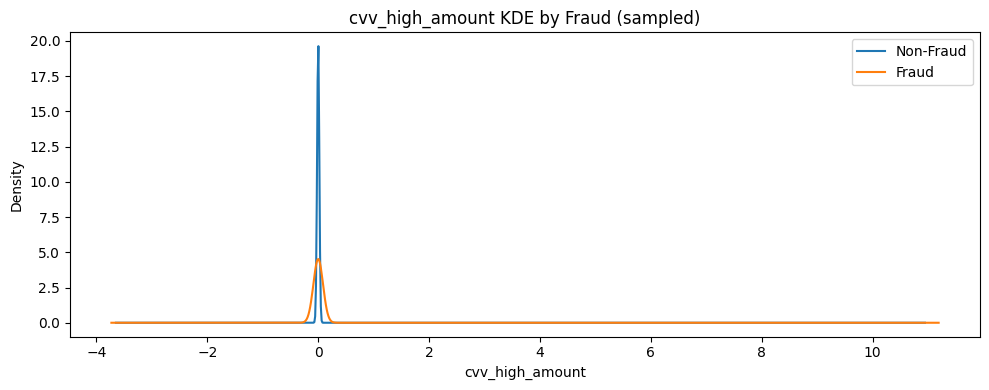

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


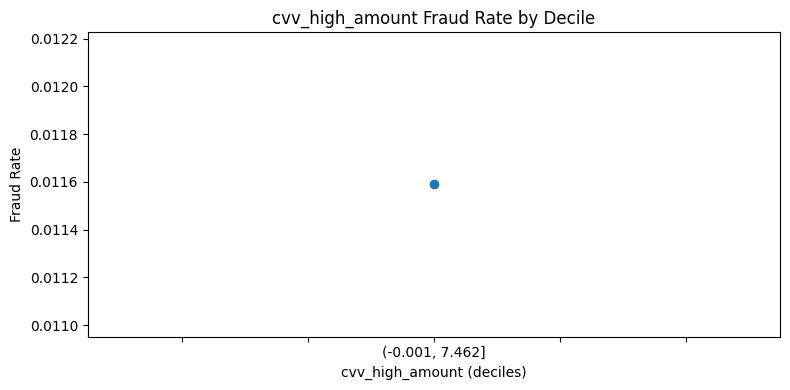

[0 vs non-zero] cvv_high_amount: fraud_rate(0)=0.011453, fraud_rate(nonzero)=0.045002, nonzero_rate=0.0041


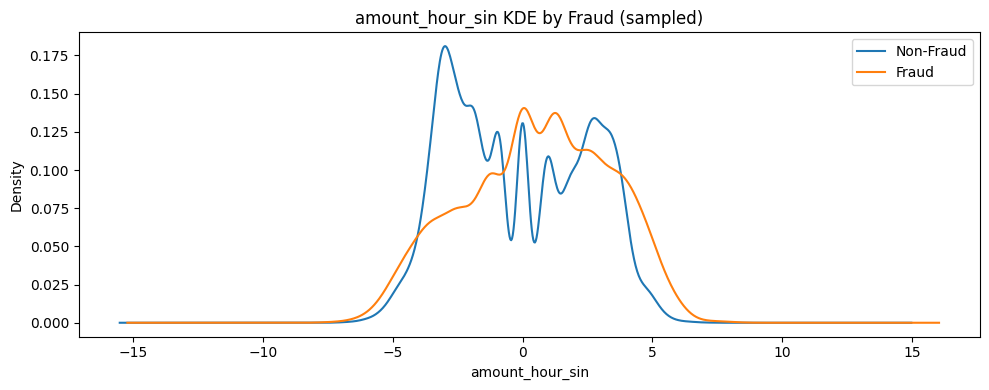

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


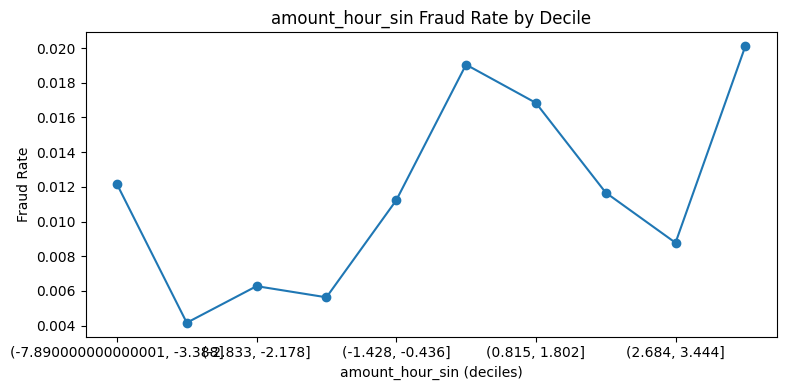

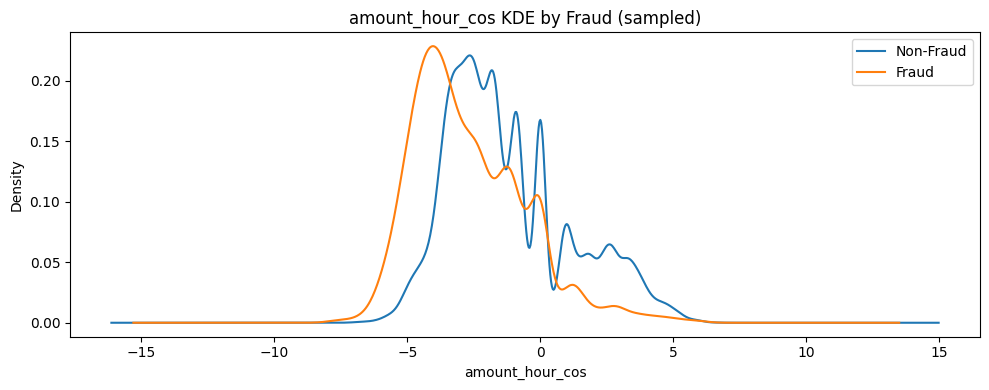

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


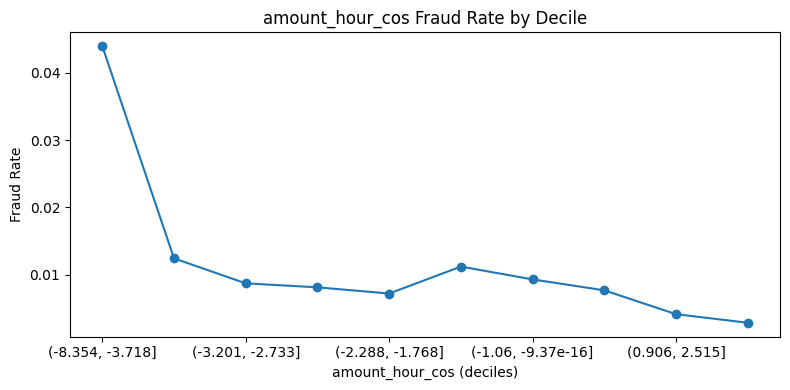

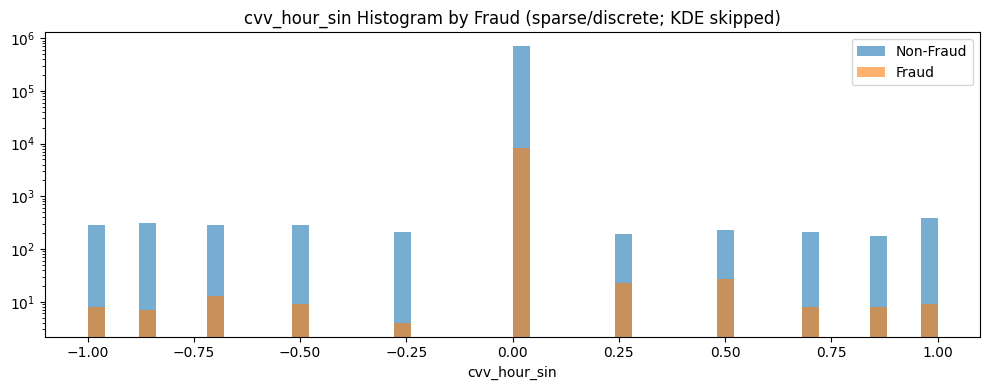

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


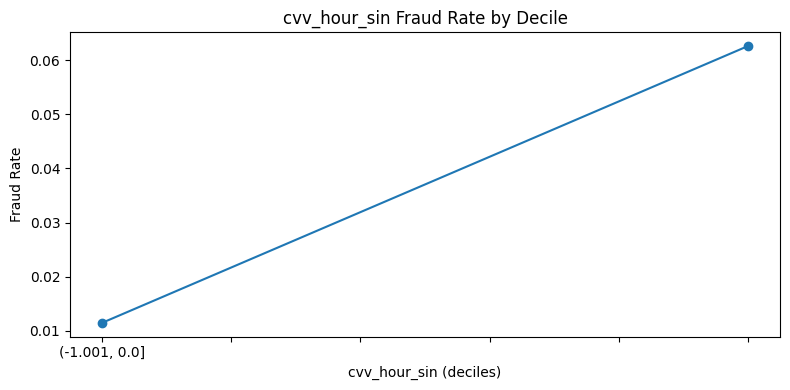

[0 vs non-zero] cvv_hour_sin: fraud_rate(0)=0.011452, fraud_rate(nonzero)=0.045724, nonzero_rate=0.0040


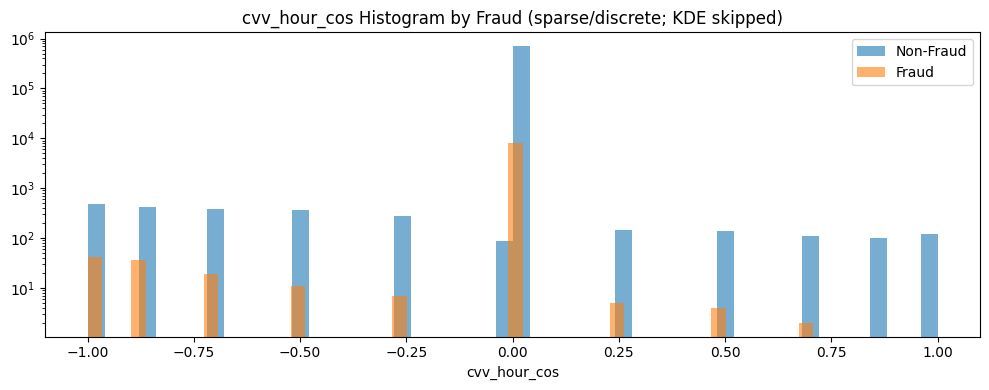

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


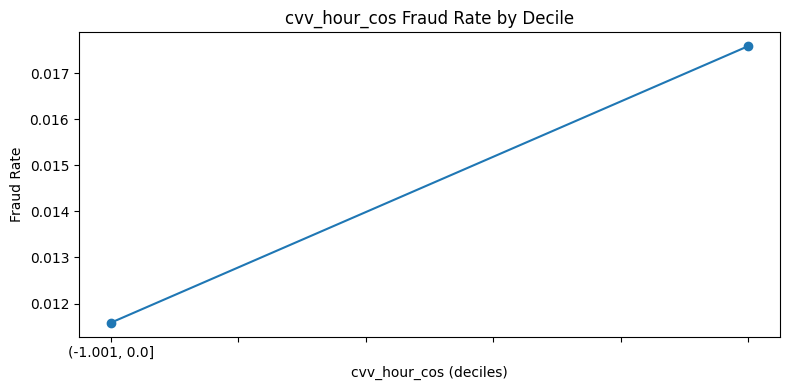

[0 vs non-zero] cvv_hour_cos: fraud_rate(0)=0.011453, fraud_rate(nonzero)=0.045002, nonzero_rate=0.0041


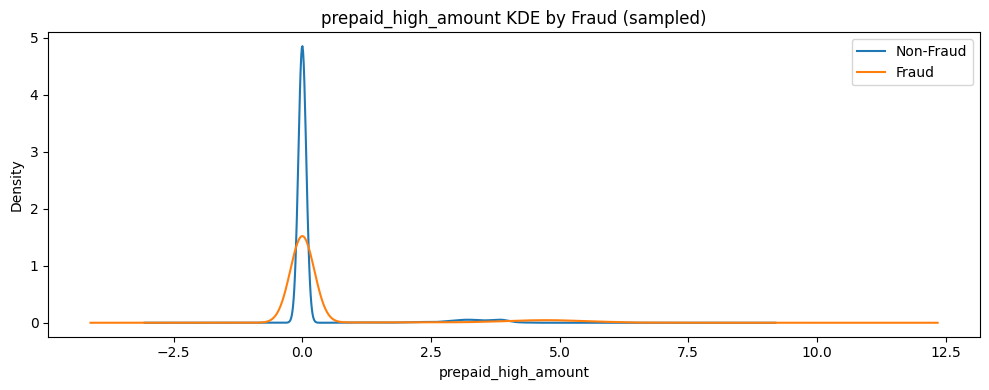

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


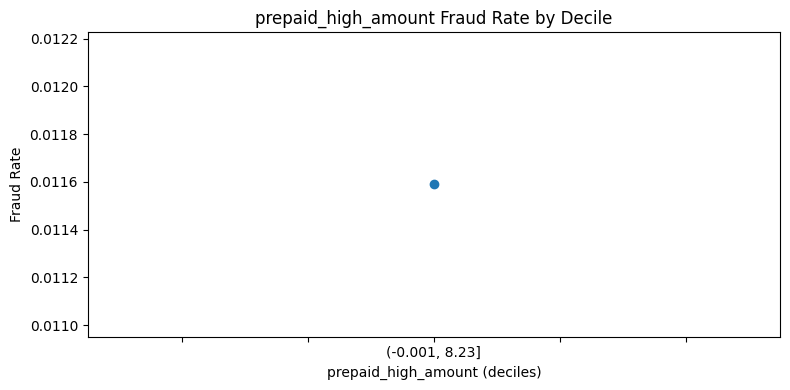

[0 vs non-zero] prepaid_high_amount: fraud_rate(0)=0.011141, fraud_rate(nonzero)=0.017017, nonzero_rate=0.0763


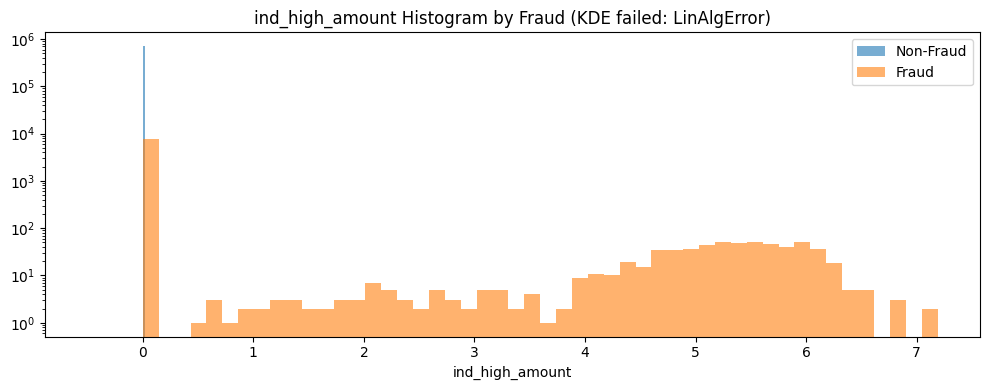

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


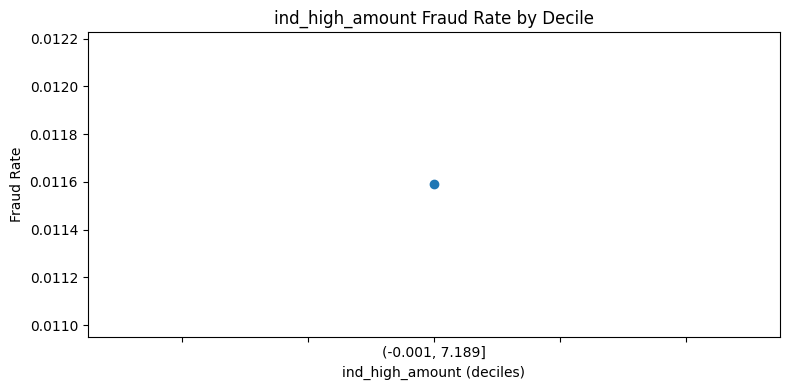

[0 vs non-zero] ind_high_amount: fraud_rate(0)=0.010696, fraud_rate(nonzero)=1.000000, nonzero_rate=0.0009


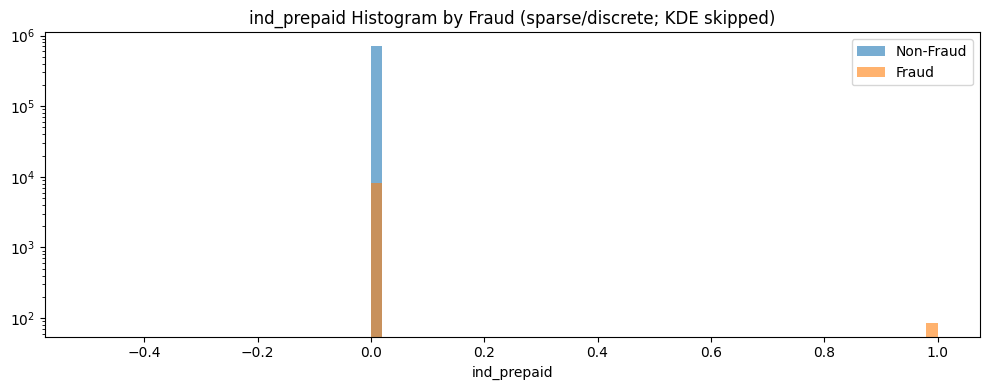

/tmp/ipykernel_4135145/2242752698.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = df2.groupby(bins)["fraud"].mean()


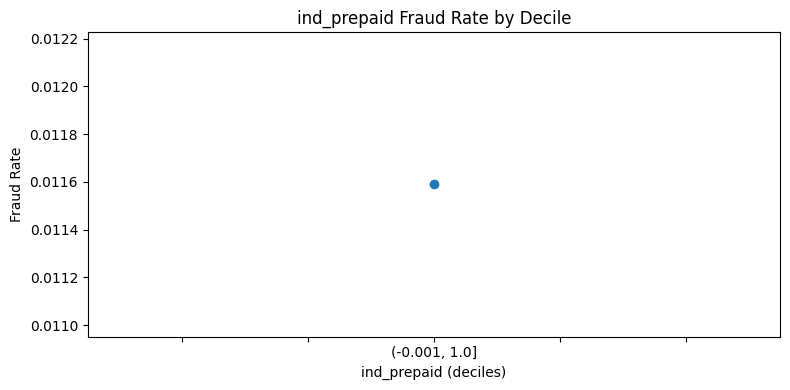

[0 vs non-zero] ind_prepaid: fraud_rate(0)=0.011471, fraud_rate(nonzero)=1.000000, nonzero_rate=0.0001


In [33]:
for c in [
    "cvv_high_amount",
    "amount_hour_sin", "amount_hour_cos",
    "cvv_hour_sin", "cvv_hour_cos",
    "prepaid_high_amount",
    "ind_high_amount",
    "ind_prepaid",
]:
    plot_interaction_feature_safe(df, c)


In [34]:

def evaluate_numeric_feature_safe(df, feature):
    s = df[feature]
    y = df["fraud"]

    m = s.notna() & y.notna()
    s = s[m]
    y = y[m]

    x_nf = s[y == 0]
    x_f  = s[y == 1]

    ks_stat, ks_p = ks_2samp(x_nf, x_f)
    mw_stat, mw_p = mannwhitneyu(x_nf, x_f, alternative="two-sided")

    def cohens_d(x, z):
        nx, nz = len(x), len(z)
        pooled_std = np.sqrt(((nx-1)*x.std()**2 + (nz-1)*z.std()**2) / (nx+nz-2))
        return (x.mean() - z.mean()) / pooled_std

    d = cohens_d(x_f, x_nf)

    pr_auc = average_precision_score(y, s)

    # logit (실패하면 NaN 처리)
    odds_ratio = np.nan
    logit_p = np.nan
    try:
        X = sm.add_constant(s.to_frame())
        model = sm.Logit(y, X).fit(disp=0)
        odds_ratio = float(np.exp(model.params[feature]))
        logit_p = float(model.pvalues[feature])
    except Exception:
        pass

    return pd.Series({
        "KS_p": ks_p,
        "MW_p": mw_p,
        "Cohen_d": d,
        "Odds_Ratio": odds_ratio,
        "Logit_p": logit_p,
        "PR_AUC": pr_auc,
        "n": len(s),
        "pos_rate": float(y.mean())
    })


In [35]:
for c in [
    "cvv_high_amount",
    "amount_hour_sin", "amount_hour_cos",
    "cvv_hour_sin", "cvv_hour_cos",
    "prepaid_high_amount",
    "ind_high_amount",
    "ind_prepaid",
]:
    print(f"{c}")
    print(evaluate_numeric_feature_safe(df, c))

cvv_high_amount
KS_p          1.971115e-01
MW_p          4.746463e-64
Cohen_d       1.983516e-01
Odds_Ratio    1.435678e+00
Logit_p       3.124711e-60
PR_AUC        1.293632e-02
n             7.155650e+05
pos_rate      1.158944e-02
dtype: float64
amount_hour_sin
KS_p          2.642943e-198
MW_p          2.696674e-132
Cohen_d        2.725802e-01
Odds_Ratio     1.107807e+00
Logit_p       2.004236e-132
PR_AUC         1.954481e-02
n              7.155650e+05
pos_rate       1.158944e-02
dtype: float64
amount_hour_cos
KS_p               0.000000
MW_p               0.000000
Cohen_d           -0.635445
Odds_Ratio         0.686365
Logit_p            0.000000
PR_AUC             0.007666
n             715565.000000
pos_rate           0.011589
dtype: float64
cvv_hour_sin
KS_p          5.250117e-01
MW_p          1.562039e-17
Cohen_d       3.572844e-02
Odds_Ratio    2.102342e+00
Logit_p       8.866263e-04
PR_AUC        1.194899e-02
n             7.155650e+05
pos_rate      1.158944e-02
dtype: float64

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.043416e-43
MW_p          0.000000e+00
Cohen_d       2.623451e+00
Odds_Ratio    4.299357e+61
Logit_p       9.309816e-01
PR_AUC        8.858368e-02
n             7.155650e+05
pos_rate      1.158944e-02
dtype: float64
ind_prepaid
KS_p               0.339006
MW_p               0.000000
Cohen_d            0.950879
Odds_Ratio              NaN
Logit_p                 NaN
PR_AUC             0.021839
n             715565.000000
pos_rate           0.011589
dtype: float64


In [ ]:
# df.drop(columns=["amount_hour_cos", "ind_prepaid", "cvv_hour_sin"], inplace=True)

In [ ]:
# df.to_parquet("data/dataset2")

In [21]:
import pandas as pd
df = pd.read_parquet("../data/dataset2")

In [22]:
df.shape

(715565, 48)

In [23]:
df.columns

Index(['client_id', 'card_id', 'current_age', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards',
       'has_chip', 'credit_limit', 'year_pin_last_changed',
       'err_bad_card_number', 'err_bad_expiration', 'err_bad_cvv',
       'err_insufficient_balance', 'months_to_expire', 'tx_year', 'tx_month',
       'tx_hour', 'is_weekend', 'is_credit', 'is_prepaid', 'male',
       'mccg_Food_Daily', 'mccg_Transport_Travel', 'mccg_Digital_Online',
       'mccg_Financial', 'mccg_Retail', 'mccg_Entertainment',
       'mccg_Automotive_Home', 'mccg_Utilities_Government',
       'mccg_Professional_Services', 'mccg_Industrial_/_Manufacturing',
       'cb_Visa', 'cb_Mastercard', 'cb_Amex', 'cb_Discover', 'fraud',
       'log_amount', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
       'cvv_high_amount', 'amount_hour_sin', 'cvv_hour_cos',
       'prepaid_high_amount', 'ind_high_amount'],
      dtype='object')

In [24]:
# Multi-model evaluation with tqdm (PR-AUC / ROC-AUC / Confusion Matrix / Classification Report)
# - Uses time-based split (tx_year/tx_month/tx_day/tx_hour if available; else falls back)
# - Numeric-only pipeline + imputer
# - Runs: Logit, HGB, (optional) XGB, (optional) LGBM
# - Picks threshold either by target_recall (default 0.70) or best-F1

from __future__ import annotations

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
)

# optional
try:
    from sklearn.ensemble import HistGradientBoostingClassifier
    _HGB_AVAILABLE = True
except Exception:
    _HGB_AVAILABLE = False

try:
    from xgboost import XGBClassifier
    _XGB_AVAILABLE = True
except Exception:
    _XGB_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    _LGBM_AVAILABLE = True
except Exception:
    _LGBM_AVAILABLE = False


LABEL = "fraud"

# -----------------------------
# split helpers
# -----------------------------
def _make_time_index(df: pd.DataFrame) -> pd.Series:
    # Prefer day if present; otherwise just year-month-hour (less ideal)
    has_day = "tx_day" in df.columns
    if has_day:
        return (
            df["tx_year"].astype(np.int64) * 1000000
            + df["tx_month"].astype(np.int64) * 10000
            + df["tx_day"].astype(np.int64) * 100
            + df["tx_hour"].astype(np.int64)
        )
    else:
        return (
            df["tx_year"].astype(np.int64) * 10000
            + df["tx_month"].astype(np.int64) * 100
            + df["tx_hour"].astype(np.int64)
        )

def time_split_df(df: pd.DataFrame, valid_ratio: float = 0.2, seed: int = 42):
    df2 = df.copy()
    if {"tx_year", "tx_month", "tx_hour"}.issubset(df2.columns):
        df2["_t"] = _make_time_index(df2)
        df2 = df2.sort_values("_t").reset_index(drop=True)
        cut = int(np.floor(len(df2) * (1.0 - valid_ratio)))
        cut = max(1, min(cut, len(df2) - 1))
        tr = df2.iloc[:cut].drop(columns=["_t"])
        va = df2.iloc[cut:].drop(columns=["_t"])
        return tr, va, "time_split"
    else:
        tr, va = train_test_split(df2, test_size=valid_ratio, random_state=seed, stratify=df2[LABEL])
        return tr, va, "stratified_random_split"

# -----------------------------
# threshold selection
# -----------------------------
def choose_threshold(y_true: np.ndarray, y_proba: np.ndarray,
                     mode: str = "target_recall", target_recall: float = 0.70):
    """
    mode:
      - "target_recall": pick highest threshold among points with recall >= target_recall maximizing precision
      - "best_f1": pick threshold maximizing f1 on PR curve
    """
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    # thr length is len(prec)-1
    prec_t, rec_t, thr_t = prec[1:], rec[1:], thr

    if len(thr_t) == 0:
        return {"threshold": 0.5, "note": "no_thresholds"}

    if mode == "best_f1":
        f1 = (2 * prec_t * rec_t) / (prec_t + rec_t + 1e-12)
        i = int(np.argmax(f1))
        return {"threshold": float(thr_t[i]), "precision": float(prec_t[i]), "recall": float(rec_t[i]), "note": "best_f1"}

    # target_recall
    ok = rec_t >= float(target_recall)
    if not np.any(ok):
        i = int(np.argmax(rec_t))
        return {"threshold": float(thr_t[i]), "precision": float(prec_t[i]), "recall": float(rec_t[i]),
                "note": "target_recall_not_met; picked_max_recall"}

    cand = np.where(ok)[0]
    best_prec = np.max(prec_t[cand])
    bests = cand[prec_t[cand] == best_prec]
    # among same precision, choose larger threshold (fewer alerts)
    i = int(bests[np.argmax(thr_t[bests])])
    return {"threshold": float(thr_t[i]), "precision": float(prec_t[i]), "recall": float(rec_t[i]),
            "note": "picked_best_precision_under_recall_constraint"}

# -----------------------------
# model factory
# -----------------------------
def _scale_pos_weight(y: np.ndarray) -> float:
    pos = float((y == 1).sum())
    neg = float((y == 0).sum())
    return neg / max(pos, 1.0)

def make_numeric_pipeline(model_name: str, num_cols: list[str], y_train: np.ndarray,
                          *,
                          # common speed knobs
                          scaler: bool = True,
                          # logit
                          logit_C: float = 0.3, logit_max_iter: int = 200, logit_tol: float = 1e-2,
                          # hgb
                          hgb_max_depth: int = 6, hgb_max_iter: int = 200, hgb_lr: float = 0.06,
                          # xgb
                          xgb_n_estimators: int = 500, xgb_max_depth: int = 6, xgb_lr: float = 0.05,
                          xgb_subsample: float = 0.8, xgb_colsample: float = 0.8, xgb_tree_method: str = "hist",
                          # lgbm
                          lgbm_n_estimators: int = 700, lgbm_num_leaves: int = 63, lgbm_lr: float = 0.05,
                          lgbm_subsample: float = 0.8, lgbm_colsample: float = 0.8,
                          ):
    # preprocessing
    steps = [("imp", SimpleImputer(strategy="median"))]
    if scaler:
        steps.append(("scaler", StandardScaler(with_mean=False)))
    pre_num = Pipeline(steps)

    pre = ColumnTransformer(
        transformers=[("num", pre_num, num_cols)],
        remainder="drop",
        sparse_threshold=0.3,
    )

    name = model_name.lower()

    if name == "logit":
        clf = LogisticRegression(
            solver="saga",
            C=logit_C,
            max_iter=logit_max_iter,
            tol=logit_tol,
            class_weight="balanced",
            n_jobs=-1,
        )
        return Pipeline([("pre", pre), ("clf", clf)])

    if name == "hgb":
        if not _HGB_AVAILABLE:
            raise RuntimeError("HistGradientBoostingClassifier not available")
        # HGB doesn't need scaling; but keep pre anyway (imputer)
        clf = HistGradientBoostingClassifier(
            max_depth=hgb_max_depth,
            max_iter=hgb_max_iter,
            learning_rate=hgb_lr,
        )
        return Pipeline([("pre", pre), ("clf", clf)])

    if name == "xgb":
        if not _XGB_AVAILABLE:
            raise RuntimeError("xgboost not available")
        spw = _scale_pos_weight(y_train)
        clf = XGBClassifier(
            n_estimators=xgb_n_estimators,
            max_depth=xgb_max_depth,
            learning_rate=xgb_lr,
            subsample=xgb_subsample,
            colsample_bytree=xgb_colsample,
            tree_method=xgb_tree_method,
            n_jobs=-1,
            random_state=42,
            objective="binary:logistic",
            eval_metric="aucpr",
            scale_pos_weight=spw,
        )
        return Pipeline([("pre", pre), ("clf", clf)])

    if name == "lgbm":
        if not _LGBM_AVAILABLE:
            raise RuntimeError("lightgbm not available")
        clf = LGBMClassifier(
            n_estimators=lgbm_n_estimators,
            num_leaves=lgbm_num_leaves,
            learning_rate=lgbm_lr,
            subsample=lgbm_subsample,
            colsample_bytree=lgbm_colsample,
            n_jobs=-1,
            random_state=42,
            objective="binary",
            class_weight="balanced",
        )
        return Pipeline([("pre", pre), ("clf", clf)])

    raise ValueError(f"Unknown model_name: {model_name}")

# -----------------------------
# main eval
# -----------------------------
def evaluate_models(
    df: pd.DataFrame,
    *,
    label_col: str = LABEL,
    drop_cols: tuple[str, ...] = ("client_id", "card_id"),
    valid_ratio: float = 0.2,
    threshold_mode: str = "target_recall",  # "target_recall" or "best_f1"
    target_recall: float = 0.70,
    # speed knobs
    max_rows: int | None = 250_000,      # set None to use full
    seed: int = 42,
    models: list[str] | None = None,
    verbose_reports: bool = True,
):
    df0 = df.copy()

    # optional subsample for speed (stratified)
    if max_rows is not None and len(df0) > max_rows:
        df0 = df0.sample(max_rows, random_state=seed, replace=False)
        # keep class ratio roughly (not perfect unless stratified; you can stratify via concat trick)
    df0 = df0.dropna(subset=[label_col]).copy()

    # split
    tr_df, va_df, split_name = time_split_df(df0, valid_ratio=valid_ratio, seed=seed)

    # schema
    feature_cols = [c for c in df0.columns if c != label_col and c not in set(drop_cols)]
    # numeric-only
    num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df0[c])]

    X_tr = tr_df[num_cols]
    y_tr = tr_df[label_col].astype(int).to_numpy()
    X_va = va_df[num_cols]
    y_va = va_df[label_col].astype(int).to_numpy()

    if models is None:
        models = ["logit", "hgb"]
        if _XGB_AVAILABLE:
            models.append("xgb")
        if _LGBM_AVAILABLE:
            models.append("lgbm")

    rows = []
    reports = {}  # model_name -> classification_report dict

    pbar = tqdm(models, desc=f"Eval models ({split_name})", leave=True)
    for m in pbar:
        try:
            # choose scaler: good for logit; unnecessary for trees
            use_scaler = (m.lower() == "logit")

            pipe = make_numeric_pipeline(
                m, num_cols, y_tr,
                scaler=use_scaler,
                # speed defaults (tune if needed)
                logit_C=0.3, logit_max_iter=200, logit_tol=1e-2,
                hgb_max_depth=6, hgb_max_iter=200, hgb_lr=0.06,
                xgb_n_estimators=500, xgb_max_depth=6, xgb_lr=0.05,
                lgbm_n_estimators=700, lgbm_num_leaves=63, lgbm_lr=0.05,
            )

            pbar.set_postfix_str(f"{m}: fit")
            pipe.fit(X_tr, y_tr)

            pbar.set_postfix_str(f"{m}: predict")
            proba = pipe.predict_proba(X_va)[:, 1]

            pr_auc = float(average_precision_score(y_va, proba))
            roc_auc = float(roc_auc_score(y_va, proba))

            thr_info = choose_threshold(y_va, proba, mode=threshold_mode, target_recall=target_recall)
            thr = float(thr_info["threshold"])
            yhat = (proba >= thr).astype(int)
            cm = confusion_matrix(y_va, yhat)

            cls = classification_report(y_va, yhat, digits=4, output_dict=True)
            reports[m] = cls

            rows.append({
                "model": m,
                "split": split_name,
                "rows_used": int(len(df0)),
                "n_train": int(len(tr_df)),
                "n_valid": int(len(va_df)),
                "pos_rate_train": float(tr_df[label_col].mean()),
                "pos_rate_valid": float(va_df[label_col].mean()),
                "n_num_features": int(len(num_cols)),
                "PR_AUC": pr_auc,
                "ROC_AUC": roc_auc,
                "thr": thr,
                "thr_note": thr_info.get("note", ""),
                "precision@thr": float(cls.get("1", {}).get("precision", np.nan)),
                "recall@thr": float(cls.get("1", {}).get("recall", np.nan)),
                "f1@thr": float(cls.get("1", {}).get("f1-score", np.nan)),
                "CM_TN": int(cm[0,0]), "CM_FP": int(cm[0,1]),
                "CM_FN": int(cm[1,0]), "CM_TP": int(cm[1,1]),
            })

        except Exception as e:
            rows.append({"model": m, "error": repr(e), "rows_used": int(len(df0)), "split": split_name})

    summary = pd.DataFrame(rows).sort_values(by="PR_AUC", ascending=False, na_position="last").reset_index(drop=True)

    if verbose_reports:
        # print compact report for best model
        best = summary.dropna(subset=["PR_AUC"]).iloc[0]["model"] if summary["PR_AUC"].notna().any() else None
        if best is not None:
            print("\n=== BEST MODEL:", best, "===\n")
            print("Summary row:")
            print(summary[summary["model"] == best][[
                "model","PR_AUC","ROC_AUC","thr","thr_note","precision@thr","recall@thr","f1@thr",
                "CM_TN","CM_FP","CM_FN","CM_TP"
            ]])
            print("\nClassification report (dict):")
            # pretty-print a few keys
            cr = reports[best]
            for k in ["0", "1", "macro avg", "weighted avg"]:
                if k in cr:
                    print(k, cr[k])

    return summary, reports


# -----------------------------
# USAGE
# -----------------------------
# 1) Make sure df already contains your new interaction features, and label column "fraud".
# 2) Run this (adjust max_rows=None for full run if you can afford it):

summary, reports = evaluate_models(
    df,
    drop_cols=("client_id", "card_id"),   # keep for system keys, drop for model
    valid_ratio=0.21,
    threshold_mode="target_recall",       # or "best_f1"
    target_recall=0.70,
    max_rows=250_000,                     # set None for full
    models=None,                          # auto: logit/hgb + xgb/lgbm if installed
    verbose_reports=True
)

summary


Eval models (time_split):   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1862, number of negative: 195638
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 197500, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

=== BEST MODEL: hgb ===

Summary row:
  model    PR_AUC   ROC_AUC       thr  \
0   hgb  0.372982  0.925119  0.013974   

                                        thr_note  precision@thr  recall@thr  \
0  picked_best_precision_under_recall_constraint       0.149594    0.700205   

     f1@thr  CM_TN  CM_FP  CM_FN  CM_TP  
0  0.246521  47649   3877    292    682  

Classification report (dict):
0 {'precision': 0.9939091800337916, 'recall': 0

/home/nakyung/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,split,rows_used,n_train,n_valid,pos_rate_train,pos_rate_valid,n_num_features,PR_AUC,ROC_AUC,thr,thr_note,precision@thr,recall@thr,f1@thr,CM_TN,CM_FP,CM_FN,CM_TP
0,hgb,time_split,250000,197500,52500,0.009428,0.018552,45,0.372982,0.925119,0.013974,picked_best_precision_under_recall_constraint,0.149594,0.700205,0.246521,47649,3877,292,682
1,lgbm,time_split,250000,197500,52500,0.009428,0.018552,45,0.306078,0.887110,0.002691,picked_best_precision_under_recall_constraint,0.104939,0.700205,0.182524,45709,5817,292,682
2,xgb,time_split,250000,197500,52500,0.009428,0.018552,45,0.266953,0.898174,0.038317,picked_best_precision_under_recall_constraint,0.110876,0.700205,0.191439,46057,5469,292,682
3,logit,time_split,250000,197500,52500,0.009428,0.018552,45,0.253035,0.885789,0.955275,picked_best_precision_under_recall_constraint,0.117769,0.700205,0.201626,46417,5109,292,682


In [25]:
# HGB Ablation Test (tqdm) — check whether NEW interaction features truly improve PR-AUC / ROC-AUC
# - Runs multiple feature-sets (baseline vs +each interaction vs +all)
# - Uses SAME time split (no re-sampling per run) for fair comparison
# - Threshold picked by target recall (default 0.70)
# - Prints PR-AUC/ROC-AUC/precision/recall/F1/CM and returns a summary DF

from __future__ import annotations
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, confusion_matrix, classification_report,
)

from sklearn.ensemble import HistGradientBoostingClassifier

LABEL = "fraud"

# -----------------------------
# reuse: time index + split
# -----------------------------
def _make_time_index(df: pd.DataFrame) -> pd.Series:
    has_day = "tx_day" in df.columns
    if has_day:
        return (
            df["tx_year"].astype(np.int64) * 1000000
            + df["tx_month"].astype(np.int64) * 10000
            + df["tx_day"].astype(np.int64) * 100
            + df["tx_hour"].astype(np.int64)
        )
    return (
        df["tx_year"].astype(np.int64) * 10000
        + df["tx_month"].astype(np.int64) * 100
        + df["tx_hour"].astype(np.int64)
    )

def time_split_df_fixed(df: pd.DataFrame, valid_ratio: float = 0.21):
    df2 = df.copy()
    df2["_t"] = _make_time_index(df2)
    df2 = df2.sort_values("_t").reset_index(drop=True)
    cut = int(np.floor(len(df2) * (1.0 - valid_ratio)))
    cut = max(1, min(cut, len(df2) - 1))
    tr = df2.iloc[:cut].drop(columns=["_t"])
    va = df2.iloc[cut:].drop(columns=["_t"])
    return tr, va, "time_split"

# -----------------------------
# reuse: threshold by target recall
# -----------------------------
def choose_threshold_by_target_recall(y_true, y_proba, target_recall=0.70):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    prec_t, rec_t, thr_t = prec[1:], rec[1:], thr
    if len(thr_t) == 0:
        return {"threshold": 0.5, "note": "no_thresholds"}

    ok = rec_t >= float(target_recall)
    if not np.any(ok):
        i = int(np.argmax(rec_t))
        return {"threshold": float(thr_t[i]), "precision": float(prec_t[i]), "recall": float(rec_t[i]),
                "note": "target_recall_not_met; picked_max_recall"}

    cand = np.where(ok)[0]
    best_prec = np.max(prec_t[cand])
    bests = cand[prec_t[cand] == best_prec]
    i = int(bests[np.argmax(thr_t[bests])])  # larger threshold = fewer alerts
    return {"threshold": float(thr_t[i]), "precision": float(prec_t[i]), "recall": float(rec_t[i]),
            "note": "picked_best_precision_under_recall_constraint"}

# -----------------------------
# HGB pipeline builder (numeric only)
# -----------------------------
def build_hgb_pipeline(num_cols, *, max_depth=6, max_iter=200, learning_rate=0.06):
    pre = ColumnTransformer(
        transformers=[("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols)],
        remainder="drop",
        sparse_threshold=0.3,
    )
    clf = HistGradientBoostingClassifier(
        max_depth=max_depth,
        max_iter=max_iter,
        learning_rate=learning_rate,
    )
    return Pipeline([("pre", pre), ("clf", clf)])

# -----------------------------
# Ablation runner
# -----------------------------
def hgb_ablation(
    df: pd.DataFrame,
    *,
    label_col: str = LABEL,
    drop_cols: tuple[str, ...] = ("client_id", "card_id"),
    # interactions you want to test (existing columns in df)
    inter_cols: list[str] = None,
    valid_ratio: float = 0.21,
    target_recall: float = 0.70,
    # for speed
    max_rows: int | None = 250_000,
    seed: int = 42,
    # hgb hyperparams
    hgb_max_depth: int = 6,
    hgb_max_iter: int = 200,
    hgb_lr: float = 0.06,
):
    if inter_cols is None:
        inter_cols = [
            "cvv_high_amount",
            "prepaid_high_amount",
            "ind_high_amount",
            "amount_hour_sin", "amount_hour_cos",
            "cvv_hour_sin", "cvv_hour_cos",
            "ind_prepaid",
        ]

    df0 = df.copy()
    df0 = df0.dropna(subset=[label_col]).copy()

    # optional sample once (IMPORTANT: sample only once, not per run)
    if max_rows is not None and len(df0) > max_rows:
        df0 = df0.sample(max_rows, random_state=seed, replace=False).reset_index(drop=True)

    # fixed time split ONCE for fairness
    tr_df, va_df, split_name = time_split_df_fixed(df0, valid_ratio=valid_ratio)

    # base feature cols (exclude label and system IDs)
    base_cols = [c for c in df0.columns if c != label_col and c not in set(drop_cols)]

    # ensure inter cols exist
    inter_cols = [c for c in inter_cols if c in df0.columns]

    # define experiment sets:
    # - baseline: remove ALL interaction columns
    # - +each: baseline + one interaction
    # - +all: baseline + all interactions
    baseline_cols = [c for c in base_cols if c not in set(inter_cols)]

    exp_sets = []
    exp_sets.append(("baseline(no_interactions)", baseline_cols))
    for c in inter_cols:
        exp_sets.append((f"+{c}", baseline_cols + [c]))
    exp_sets.append(("+ALL_interactions", baseline_cols + inter_cols))

    rows = []
    reports = {}

    pbar = tqdm(exp_sets, desc=f"HGB ablation ({split_name})", leave=True)
    for name, cols in pbar:
        # numeric only (should already be numeric; keep robust)
        num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df0[c])]

        X_tr = tr_df[num_cols]
        y_tr = tr_df[label_col].astype(int).to_numpy()
        X_va = va_df[num_cols]
        y_va = va_df[label_col].astype(int).to_numpy()

        pbar.set_postfix_str(f"{name}: fit ({len(num_cols)}f)")
        pipe = build_hgb_pipeline(
            num_cols,
            max_depth=hgb_max_depth,
            max_iter=hgb_max_iter,
            learning_rate=hgb_lr,
        )
        pipe.fit(X_tr, y_tr)

        pbar.set_postfix_str(f"{name}: predict")
        proba = pipe.predict_proba(X_va)[:, 1]

        pr_auc = float(average_precision_score(y_va, proba))
        roc_auc = float(roc_auc_score(y_va, proba))

        thr_info = choose_threshold_by_target_recall(y_va, proba, target_recall=target_recall)
        thr = float(thr_info["threshold"])
        yhat = (proba >= thr).astype(int)

        cm = confusion_matrix(y_va, yhat)
        cls = classification_report(y_va, yhat, digits=4, output_dict=True)
        reports[name] = cls

        rows.append({
            "exp": name,
            "rows_used": int(len(df0)),
            "n_train": int(len(tr_df)),
            "n_valid": int(len(va_df)),
            "pos_rate_train": float(tr_df[label_col].mean()),
            "pos_rate_valid": float(va_df[label_col].mean()),
            "n_num_features": int(len(num_cols)),
            "PR_AUC": pr_auc,
            "ROC_AUC": roc_auc,
            "thr": thr,
            "thr_note": thr_info.get("note",""),
            "precision@thr": float(cls.get("1", {}).get("precision", np.nan)),
            "recall@thr": float(cls.get("1", {}).get("recall", np.nan)),
            "f1@thr": float(cls.get("1", {}).get("f1-score", np.nan)),
            "CM_TN": int(cm[0,0]), "CM_FP": int(cm[0,1]),
            "CM_FN": int(cm[1,0]), "CM_TP": int(cm[1,1]),
        })

    out = pd.DataFrame(rows).sort_values("PR_AUC", ascending=False).reset_index(drop=True)

    # add delta vs baseline for quick read
    base_row = out[out["exp"] == "baseline(no_interactions)"]
    if len(base_row) == 1:
        base_pr = float(base_row["PR_AUC"].iloc[0])
        base_roc = float(base_row["ROC_AUC"].iloc[0])
        out["dPR_vs_base"] = out["PR_AUC"] - base_pr
        out["dROC_vs_base"] = out["ROC_AUC"] - base_roc

    return out, reports


# -----------------------------
# RUN
# -----------------------------
# Make sure df already has the interaction columns you created.
ablation_summary, ablation_reports = hgb_ablation(
    df,
    drop_cols=("client_id", "card_id"),
    inter_cols=[
        "cvv_high_amount",
        "amount_hour_sin", "amount_hour_cos",
        "cvv_hour_sin", "cvv_hour_cos",
        "prepaid_high_amount",
        "ind_high_amount",
        "ind_prepaid",
    ],
    valid_ratio=0.21,
    target_recall=0.70,
    max_rows=250_000,      # set None to run full
    hgb_max_depth=6,
    hgb_max_iter=200,
    hgb_lr=0.06,
)

ablation_summary


HGB ablation (time_split):   0%|          | 0/7 [00:00<?, ?it/s]

,exp,rows_used,n_train,n_valid,pos_rate_train,pos_rate_valid,n_num_features,PR_AUC,ROC_AUC,thr,thr_note,precision@thr,recall@thr,f1@thr,CM_TN,CM_FP,CM_FN,CM_TP,dPR_vs_base,dROC_vs_base
0,+ALL_interactions,250000,197500,52500,0.009428,0.018552,45,0.395036,0.929674,0.017023,picked_best_precision_under_recall_constraint,0.151475,0.701232,0.249134,47700,3826,291,683,0.034207,0.008507
1,+ind_high_amount,250000,197500,52500,0.009428,0.018552,41,0.381967,0.927280,0.014275,picked_best_precision_under_recall_constraint,0.146226,0.700205,0.241930,47544,3982,292,682,0.021139,0.006114
2,+amount_hour_sin,250000,197500,52500,0.009428,0.018552,41,0.378224,0.927640,0.013284,picked_best_precision_under_recall_constraint,0.145230,0.700205,0.240564,47512,4014,292,682,0.017396,0.006473
3,+cvv_hour_cos,250000,197500,52500,0.009428,0.018552,41,0.362268,0.922011,0.010062,picked_best_precision_under_recall_constraint,0.128953,0.703285,0.217945,46899,4627,289,685,0.001439,0.000845
4,baseline(no_interactions),250000,197500,52500,0.009428,0.018552,40,0.360828,0.921167,0.011126,picked_best_precision_under_recall_constraint,0.133580,0.703285,0.224517,47083,4443,289,685,0.000000,0.000000
5,+cvv_high_amount,250000,197500,52500,0.009428,0.018552,41,0.353884,0.922699,0.010999,picked_best_precision_under_recall_constraint,0.138991,0.701232,0.231997,47295,4231,291,683,-0.006945,0.001532
6,+prepaid_high_amount,250000,197500,52500,0.009428,0.018552,41,0.347340,0.923047,0.011419,picked_best_precision_under_recall_constraint,0.138731,0.700205,0.231579,47292,4234,292,682,-0.013488,0.001880


In [26]:
df.drop(columns=["cvv_hour_cos", "cvv_high_amount"], inplace=True)

## **TreeSHAP (TreeExplainer)**

### 📦 SHAP 종류 정리

| 종류                | 대상 모델                                     | 속도       | 특징             |
| ----------------- | ----------------------------------------- | -------- | -------------- |
| **TreeExplainer** | XGBoost, LightGBM, CatBoost, RandomForest | 🚀 매우 빠름 | 정확한 SHAP 계산 가능 |
| KernelExplainer   | 모든 모델                                     | 🐢 매우 느림 | 모델 불문 가능 (근사)  |
| LinearExplainer   | 선형모델                                      | 빠름       | closed-form 계산 |
| DeepExplainer     | 딥러닝                                       | 중간       | NN 전용          |

PR-AUC: 0.26407831437954976
ROC-AUC: 0.89003500013161


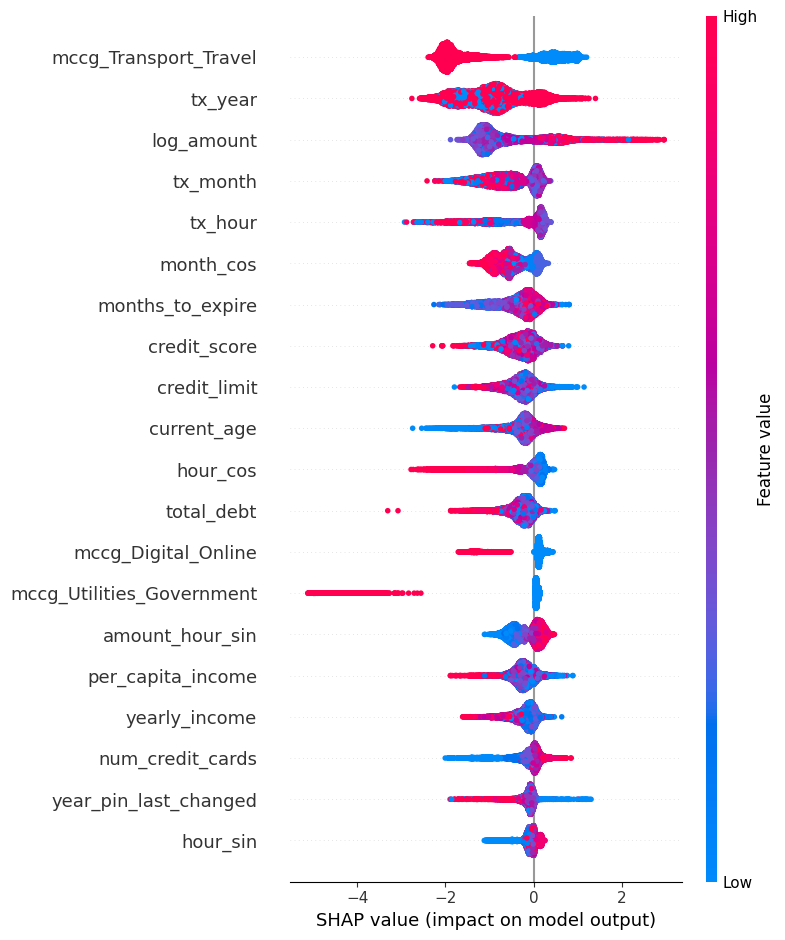

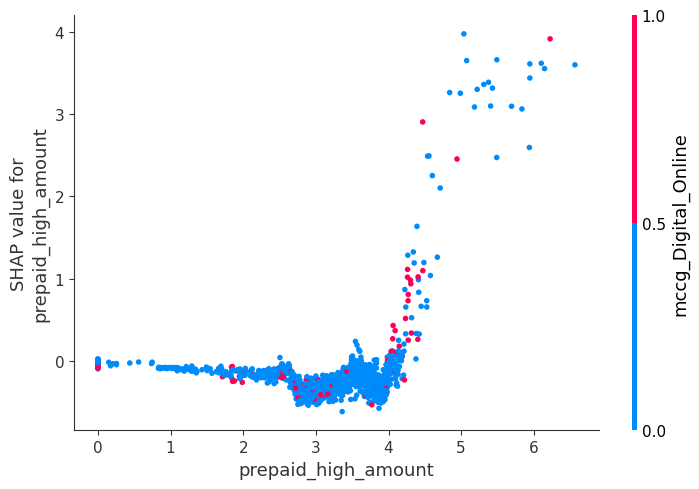

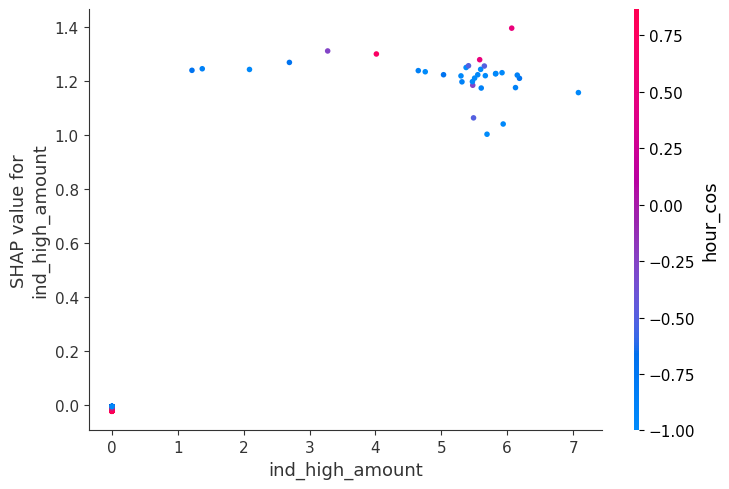

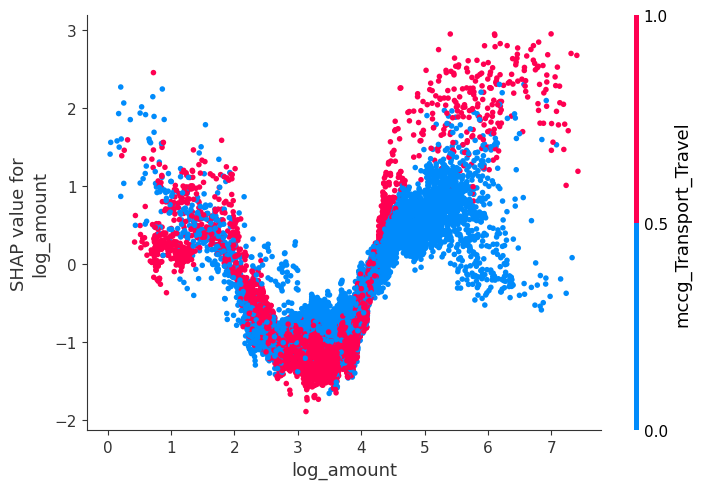

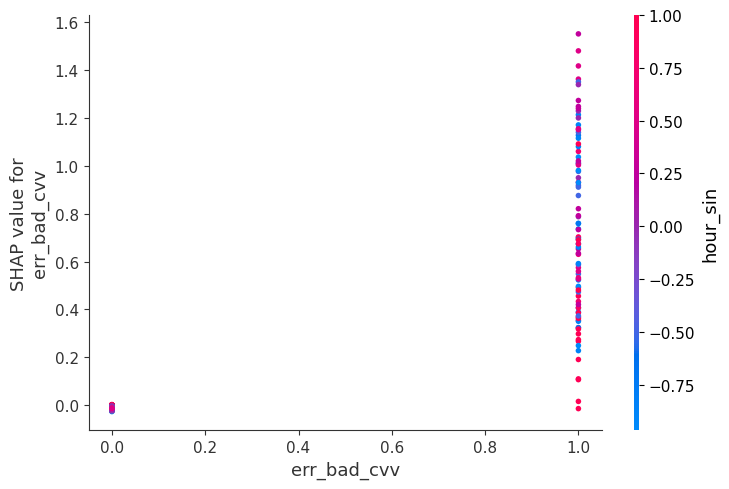

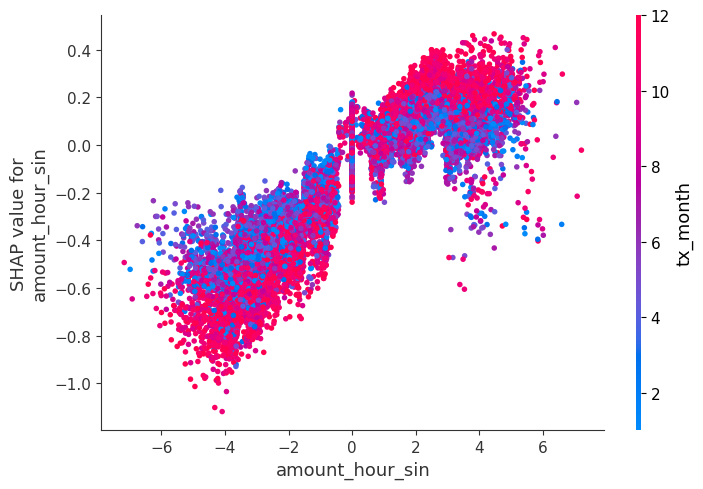

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, roc_auc_score


def xgb_native_shap(
    df,
    valid_ratio=0.21,
    n_estimators=800,
    max_depth=6,
    lr=0.05,
    subsample=0.8,
    colsample=0.8,
    seed=42,
    n_eval=20000,      # 설명할 validation 샘플 수
):
    # 1) split
    out = time_split_df(df, valid_ratio=valid_ratio)
    if len(out) == 3:
        train_df, valid_df, _ = out
    else:
        train_df, valid_df = out

    X_tr, y_tr, feat_cols = build_xy(train_df)
    X_va, y_va, _ = build_xy(valid_df)

    # 2) impute
    imp = SimpleImputer(strategy="median")
    X_tr_i = imp.fit_transform(X_tr)
    X_va_i = imp.transform(X_va)

    # 3) class imbalance
    pos = int((y_tr == 1).sum())
    neg = int((y_tr == 0).sum())
    spw = float(neg / max(pos, 1))

    # 4) XGB (GPU, XGBoost 3.x)
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=lr,
        subsample=subsample,
        colsample_bytree=colsample,
        reg_lambda=1.0,
        min_child_weight=1.0,
        gamma=0.0,
        tree_method="hist",
        device="cuda",
        objective="binary:logistic",
        eval_metric="aucpr",
        scale_pos_weight=spw,
        random_state=seed,
        n_jobs=-1,
    )
    clf.fit(X_tr_i, y_tr)

    p = clf.predict_proba(X_va_i)[:, 1]
    print("PR-AUC:", average_precision_score(y_va, p))
    print("ROC-AUC:", roc_auc_score(y_va, p))

    # 5) SHAP via native XGBoost (pred_contribs=True)
    rng = np.random.default_rng(seed)
    ev_idx = rng.choice(len(X_va_i), size=min(n_eval, len(X_va_i)), replace=False)
    X_ev = X_va_i[ev_idx]
    y_ev = y_va[ev_idx]

    d_ev = xgb.DMatrix(X_ev, feature_names=feat_cols)

    # pred_contribs -> (n_samples, n_features + 1) 마지막 열이 bias(=expected value)
    contrib = clf.get_booster().predict(d_ev, pred_contribs=True)
    shap_values = contrib[:, :-1]
    expected_value = contrib[:, -1].mean()   # (샘플 평균 bias)

    # 6) summary plot
    shap.summary_plot(shap_values, features=X_ev, feature_names=feat_cols, show=False)
    plt.tight_layout()
    plt.show()

    # 7) dependence plot (중요 피처들)
    for f in ["prepaid_high_amount", "ind_high_amount", "log_amount", "err_bad_cvv",
              "amount_hour_sin", "cvv_high_amount"]:
        if f in feat_cols:
            shap.dependence_plot(f, shap_values, X_ev, feature_names=feat_cols, show=False)
            plt.tight_layout()
            plt.show()

    return {
        "model": clf,
        "imputer": imp,
        "feat_cols": feat_cols,
        "X_ev": X_ev,
        "y_ev": y_ev,
        "shap_values": shap_values,
        "expected_value": expected_value,
    }


# ✅ 실행
out = xgb_native_shap(
    df,
    valid_ratio=0.21,
    n_estimators=800,
    max_depth=6,
    lr=0.05,
    subsample=0.8,
    colsample=0.8,
    seed=42,
    n_eval=20000,
)


In [28]:
import numpy as np
import pandas as pd

def shap_global_table(out, top_k=30):
    shap_vals = out["shap_values"]          
    feat_cols = np.array(out["feat_cols"])
    X_ev = out["X_ev"]                    

    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    mean_shap = np.mean(shap_vals, axis=0)
    std_shap = np.std(shap_vals, axis=0)

    # 방향성: SHAP>0 비율 (fraud 확률을 올리는 방향으로 작동한 비율)
    pos_frac = np.mean(shap_vals > 0, axis=0)

    feat_mean = np.mean(X_ev, axis=0)
    feat_std = np.std(X_ev, axis=0)

    df_tab = pd.DataFrame({
        "feature": feat_cols,
        "mean_abs_shap": mean_abs,
        "mean_shap": mean_shap,
        "std_shap": std_shap,
        "shap_pos_frac": pos_frac,
        "feature_mean": feat_mean,
        "feature_std": feat_std,
    }).sort_values("mean_abs_shap", ascending=False)

    return df_tab.head(top_k).reset_index(drop=True)

tab = shap_global_table(out, top_k=50)
tab


,feature,mean_abs_shap,mean_shap,std_shap,shap_pos_frac,feature_mean,feature_std
0,mccg_Transport_Travel,1.346462,-0.982857,1.157845,0.33840,0.635500,0.481290
1,tx_year,1.000270,-0.936069,0.696257,0.12475,2015.751700,0.432027
2,log_amount,0.871713,-0.580227,0.761062,0.24070,3.653252,0.919752
3,tx_month,0.603995,-0.557558,0.529612,0.23715,7.494900,3.520167
4,tx_hour,0.585519,-0.449715,0.716680,0.44760,12.306300,5.210708
5,month_cos,0.528394,-0.502588,0.364461,0.14580,0.150321,0.696404
6,months_to_expire,0.424265,-0.383557,0.449692,0.17470,69.424600,22.497431
7,credit_score,0.353204,-0.308372,0.347687,0.17260,708.726900,71.104270
8,credit_limit,0.340152,-0.294073,0.320708,0.14180,16230.199950,11975.913045
9,current_age,0.334449,-0.283773,0.393922,0.16815,54.114650,15.880658


Fraud 샘플만 SHAP 평균 보기

In [30]:
import numpy as np
import pandas as pd

def shap_fraud_only_table(out, top_k=30, *, label_value=1):
    """
    out: xgb_native_shap()가 반환한 dict
      required keys: ["shap_values", "feat_cols", "X_ev", "y_ev"]

    label_value: 1이면 fraud==1만, 0이면 non-fraud만
    """
    shap_vals = out["shap_values"]                 # (n_ev, n_feat)
    feat_cols = np.array(out["feat_cols"])         # (n_feat,)
    X_ev = out["X_ev"]                             # (n_ev, n_feat)
    y_ev = out["y_ev"]                             # (n_ev,)

    # 안전 체크
    if shap_vals.shape[0] != len(y_ev) or X_ev.shape[0] != len(y_ev):
        raise ValueError(
            f"Shape mismatch: shap_vals={shap_vals.shape}, X_ev={X_ev.shape}, y_ev={len(y_ev)}. "
            "xgb_native_shap()에서 ev_idx로 뽑은 y_ev를 out에 넣었는지 확인!"
        )

    mask = (y_ev == label_value)
    n_sel = int(mask.sum())
    if n_sel == 0:
        raise ValueError(f"No samples with y_ev == {label_value} inside SHAP eval subset. Increase n_eval or stratify sampling.")

    shap_s = shap_vals[mask]
    X_s = X_ev[mask]

    mean_abs = np.mean(np.abs(shap_s), axis=0)
    mean_shap = np.mean(shap_s, axis=0)
    std_shap = np.std(shap_s, axis=0)
    pos_frac = np.mean(shap_s > 0, axis=0)

    feat_mean = np.mean(X_s, axis=0)
    feat_std = np.std(X_s, axis=0)

    df_tab = pd.DataFrame({
        "feature": feat_cols,
        "mean_abs_shap": mean_abs,
        "mean_shap": mean_shap,
        "std_shap": std_shap,
        "shap_pos_frac": pos_frac,
        "feature_mean": feat_mean,
        "feature_std": feat_std,
        "n_selected": n_sel,
        "base_pos_rate_in_ev": float(np.mean(y_ev == 1)),
        "selected_pos_rate": float(np.mean(mask)),   # label_value=1이면 fraud fraction
    }).sort_values("mean_abs_shap", ascending=False)

    return df_tab.head(top_k).reset_index(drop=True)

# ✅ fraud==1 only
fraud_tab = shap_fraud_only_table(out, top_k=50, label_value=1)
fraud_tab


,feature,mean_abs_shap,mean_shap,std_shap,shap_pos_frac,feature_mean,feature_std,n_selected,base_pos_rate_in_ev,selected_pos_rate
0,log_amount,0.927862,0.570354,0.931401,0.732861,4.380652,1.377186,423,0.02115,0.02115
1,tx_year,0.741087,-0.560321,0.707253,0.243499,2015.732861,0.442466,423,0.02115,0.02115
2,tx_month,0.686492,-0.624598,0.605802,0.271868,7.354610,3.708277,423,0.02115,0.02115
3,mccg_Transport_Travel,0.674448,0.435255,0.603126,0.903073,0.094563,0.292610,423,0.02115,0.02115
4,month_cos,0.610083,-0.578308,0.417555,0.160757,0.194441,0.701244,423,0.02115,0.02115
5,months_to_expire,0.426954,-0.361916,0.489181,0.234043,69.439716,23.125018,423,0.02115,0.02115
6,mccg_Industrial_/_Manufacturing,0.403419,0.289114,1.211197,0.078014,0.078014,0.268194,423,0.02115,0.02115
7,mccg_Digital_Online,0.357100,0.141872,0.428309,0.907801,0.092199,0.289306,423,0.02115,0.02115
8,current_age,0.321655,-0.241363,0.454678,0.274232,54.737589,16.012102,423,0.02115,0.02115
9,credit_limit,0.318161,-0.228585,0.339779,0.179669,13372.524823,10429.394279,423,0.02115,0.02115


In [31]:
nonfraud_tab = shap_fraud_only_table(out, top_k=50, label_value=0)
nonfraud_tab

,feature,mean_abs_shap,mean_shap,std_shap,shap_pos_frac,feature_mean,feature_std,n_selected,base_pos_rate_in_ev,selected_pos_rate
0,mccg_Transport_Travel,1.360982,-1.013497,1.147744,0.326199,0.647188,0.477845,19577,0.02115,0.97885
1,tx_year,1.005870,-0.944190,0.693776,0.122184,2015.752107,0.431789,19577,0.02115,0.97885
2,log_amount,0.870500,-0.605087,0.737404,0.230066,3.637536,0.900867,19577,0.02115,0.97885
3,tx_month,0.602213,-0.556109,0.527751,0.236400,7.497931,3.515929,19577,0.02115,0.97885
4,tx_hour,0.592096,-0.460177,0.717633,0.439904,12.301170,5.251485,19577,0.02115,0.97885
5,month_cos,0.526628,-0.500952,0.363055,0.145477,0.149368,0.696268,19577,0.02115,0.97885
6,months_to_expire,0.424207,-0.384025,0.448789,0.173418,69.424273,22.483678,19577,0.02115,0.97885
7,credit_score,0.354890,-0.310229,0.348672,0.171272,708.505236,71.282462,19577,0.02115,0.97885
8,credit_limit,0.340627,-0.295487,0.320135,0.140982,16291.945702,11999.621597,19577,0.02115,0.97885
9,hour_cos,0.334940,-0.190095,0.558099,0.573326,-0.355027,0.604745,19577,0.02115,0.97885


In [32]:
def shap_pos_vs_neg_delta_table(out, top_k=30):
    pos = shap_fraud_only_table(out, top_k=10_000, label_value=1)
    neg = shap_fraud_only_table(out, top_k=10_000, label_value=0)

    m = pos.merge(neg, on="feature", suffixes=("_pos", "_neg"))

    m["d_mean_abs"] = m["mean_abs_shap_pos"] - m["mean_abs_shap_neg"]
    m["d_mean"] = m["mean_shap_pos"] - m["mean_shap_neg"]
    m["d_pos_frac"] = m["shap_pos_frac_pos"] - m["shap_pos_frac_neg"]

    # fraud에서 특히 더 강하게 작동하는 피처 상위
    m = m.sort_values("d_mean_abs", ascending=False).reset_index(drop=True)
    return m.head(top_k)

delta_tab = shap_pos_vs_neg_delta_table(out, top_k=50)
delta_tab


,feature,mean_abs_shap_pos,mean_shap_pos,std_shap_pos,shap_pos_frac_pos,feature_mean_pos,feature_std_pos,n_selected_pos,base_pos_rate_in_ev_pos,selected_pos_rate_pos,...,std_shap_neg,shap_pos_frac_neg,feature_mean_neg,feature_std_neg,n_selected_neg,base_pos_rate_in_ev_neg,selected_pos_rate_neg,d_mean_abs,d_mean,d_pos_frac
0,mccg_Industrial_/_Manufacturing,0.403419,0.289114,1.211197,0.078014,0.078014,0.268194,423,0.02115,0.02115,...,0.016871,0.000000,0.000000,0.000000,19577,0.02115,0.97885,0.347753,0.344780,0.078014
1,prepaid_high_amount,0.213496,0.153713,0.748511,0.063830,0.396643,1.343238,423,0.02115,0.02115,...,0.088640,0.003984,0.249119,0.885199,19577,0.02115,0.97885,0.169714,0.193787,0.059846
2,mccg_Retail,0.183308,0.058480,0.293863,0.182033,0.179669,0.383912,423,0.02115,0.02115,...,0.091044,0.016090,0.016090,0.125823,19577,0.02115,0.97885,0.102259,0.119264,0.165943
3,ind_high_amount,0.103910,0.086151,0.329898,0.078014,0.394603,1.409574,423,0.02115,0.02115,...,0.002326,0.000000,0.000000,0.000000,19577,0.02115,0.97885,0.094262,0.095799,0.078014
4,tx_month,0.686492,-0.624598,0.605802,0.271868,7.354610,3.708277,423,0.02115,0.02115,...,0.527751,0.236400,7.497931,3.515929,19577,0.02115,0.97885,0.084279,-0.068489,0.035468
5,month_cos,0.610083,-0.578308,0.417555,0.160757,0.194441,0.701244,423,0.02115,0.02115,...,0.363055,0.145477,0.149368,0.696268,19577,0.02115,0.97885,0.083455,-0.077356,0.015280
6,log_amount,0.927862,0.570354,0.931401,0.732861,4.380652,1.377186,423,0.02115,0.02115,...,0.737404,0.230066,3.637536,0.900867,19577,0.02115,0.97885,0.057362,1.175441,0.502795
7,mccg_Digital_Online,0.357100,0.141872,0.428309,0.907801,0.092199,0.289306,423,0.02115,0.02115,...,0.488988,0.859733,0.140216,0.347211,19577,0.02115,0.97885,0.057210,0.187650,0.048068
8,mccg_Food_Daily,0.107233,0.028762,0.149976,0.442080,0.354610,0.478395,423,0.02115,0.02115,...,0.062282,0.105123,0.079123,0.269931,19577,0.02115,0.97885,0.048981,0.065370,0.336957
9,is_credit,0.096384,-0.010643,0.120989,0.628842,0.314421,0.464285,423,0.02115,0.02115,...,0.088326,0.570568,0.285028,0.451428,19577,0.02115,0.97885,0.032420,0.001661,0.058274


In [33]:
delta_tab.columns

Index(['feature', 'mean_abs_shap_pos', 'mean_shap_pos', 'std_shap_pos',
       'shap_pos_frac_pos', 'feature_mean_pos', 'feature_std_pos',
       'n_selected_pos', 'base_pos_rate_in_ev_pos', 'selected_pos_rate_pos',
       'mean_abs_shap_neg', 'mean_shap_neg', 'std_shap_neg',
       'shap_pos_frac_neg', 'feature_mean_neg', 'feature_std_neg',
       'n_selected_neg', 'base_pos_rate_in_ev_neg', 'selected_pos_rate_neg',
       'd_mean_abs', 'd_mean', 'd_pos_frac'],
      dtype='object')

In [ ]:
len(delta_tab.columns)

22

In [36]:
f = delta_tab.columns[:7]
delta_tab[f]

,feature,mean_abs_shap_pos,mean_shap_pos,std_shap_pos,shap_pos_frac_pos,feature_mean_pos,feature_std_pos
0,mccg_Industrial_/_Manufacturing,0.403419,0.289114,1.211197,0.078014,0.078014,0.268194
1,prepaid_high_amount,0.213496,0.153713,0.748511,0.063830,0.396643,1.343238
2,mccg_Retail,0.183308,0.058480,0.293863,0.182033,0.179669,0.383912
3,ind_high_amount,0.103910,0.086151,0.329898,0.078014,0.394603,1.409574
4,tx_month,0.686492,-0.624598,0.605802,0.271868,7.354610,3.708277
5,month_cos,0.610083,-0.578308,0.417555,0.160757,0.194441,0.701244
6,log_amount,0.927862,0.570354,0.931401,0.732861,4.380652,1.377186
7,mccg_Digital_Online,0.357100,0.141872,0.428309,0.907801,0.092199,0.289306
8,mccg_Food_Daily,0.107233,0.028762,0.149976,0.442080,0.354610,0.478395
9,is_credit,0.096384,-0.010643,0.120989,0.628842,0.314421,0.464285


In [38]:
s = delta_tab.columns[7:15]
delta_tab[s]

,n_selected_pos,base_pos_rate_in_ev_pos,selected_pos_rate_pos,mean_abs_shap_neg,mean_shap_neg,std_shap_neg,shap_pos_frac_neg,feature_mean_neg
0,423,0.02115,0.02115,0.055666,-0.055666,0.016871,0.000000,0.000000
1,423,0.02115,0.02115,0.043782,-0.040074,0.088640,0.003984,0.249119
2,423,0.02115,0.02115,0.081048,-0.060784,0.091044,0.016090,0.016090
3,423,0.02115,0.02115,0.009647,-0.009647,0.002326,0.000000,0.000000
4,423,0.02115,0.02115,0.602213,-0.556109,0.527751,0.236400,7.497931
5,423,0.02115,0.02115,0.526628,-0.500952,0.363055,0.145477,0.149368
6,423,0.02115,0.02115,0.870500,-0.605087,0.737404,0.230066,3.637536
7,423,0.02115,0.02115,0.299890,-0.045778,0.488988,0.859733,0.140216
8,423,0.02115,0.02115,0.058252,-0.036608,0.062282,0.105123,0.079123
9,423,0.02115,0.02115,0.063964,-0.012304,0.088326,0.570568,0.285028


In [39]:
t = delta_tab.columns[15:]
delta_tab[t]

,feature_std_neg,n_selected_neg,base_pos_rate_in_ev_neg,selected_pos_rate_neg,d_mean_abs,d_mean,d_pos_frac
0,0.000000,19577,0.02115,0.97885,0.347753,0.344780,0.078014
1,0.885199,19577,0.02115,0.97885,0.169714,0.193787,0.059846
2,0.125823,19577,0.02115,0.97885,0.102259,0.119264,0.165943
3,0.000000,19577,0.02115,0.97885,0.094262,0.095799,0.078014
4,3.515929,19577,0.02115,0.97885,0.084279,-0.068489,0.035468
5,0.696268,19577,0.02115,0.97885,0.083455,-0.077356,0.015280
6,0.900867,19577,0.02115,0.97885,0.057362,1.175441,0.502795
7,0.347211,19577,0.02115,0.97885,0.057210,0.187650,0.048068
8,0.269931,19577,0.02115,0.97885,0.048981,0.065370,0.336957
9,0.451428,19577,0.02115,0.97885,0.032420,0.001661,0.058274
